<a href="https://colab.research.google.com/github/Salma-Jamal/Sentiment-Analysis/blob/main/Arabic-Sentiment-Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Arabic Sentiment Analysis using a Bert-based model

- [Bert Model](https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter)


- Dataset We will use is the [
ASAD: A Twitter-Based Benchmark Arabic Sentiment Analysis Dataset](https://arxiv.org/pdf/2011.00578.pdf)

## Imports

In [ ]:
!pip install transformers

In [ ]:
!pip install transformers-interpret

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm_notebook
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW,BertTokenizerFast,Trainer, TrainingArguments
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader
import re
import seaborn as sns
import string
from matplotlib import pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import accuracy_score
from transformers_interpret import SequenceClassificationExplainer

## Read and clean data

In [ ]:
data = pd.read_csv("/content/sentiment_data.csv")

In [ ]:
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)

In [ ]:
train,test = train_test_split(data,test_size=0.33, random_state=42)
test,val = train_test_split(test,test_size=0.66, random_state=42)

In [ ]:
len(train), len(test) , len(val)

(36506, 6113, 11869)

In [ ]:
train.head()

,text,sentiment
16518,#اي_مدينه_سعوديه_تحبها\nمكة المُكرمة ..💕🕊\nالم...,Positive
49002,مادري من مفهمنها إنها عايشة ف صالة رياضة\nطول ...,Negative
20098,متابعيني سكان جدة بسوي قروب تطوعي للعمل الخيري...,Neutral
52656,@MCgovSA\n\n السلام عليكم ودي استفسر عن اشتراط...,Neutral
43941,@SaudiHousingCC دعم شهر 1 وشهر1 وشهر 3 مانزل ....,Neutral


In [ ]:
test.head()

,text,sentiment
27992,اس تي سي والله مااسامحكم لين يوم القيامه,Negative
3835,"""اللهم أرني عجائب قدرتك في تيسير أموري""",Neutral
31348,"يارب أيام تقول لي ""سمّي وهذا مطلبك""\n\n #حساب_...",Neutral
39072,والله @stc لو م تشوفون حل بنتكم المضروب ذا طول...,Negative
24707,#السودان - تسجيل إصابة جديدة بفيروس كورونا لير...,Neutral


In [ ]:
val.head()

,text,sentiment
21556,@eMoroor سلام عليكم هل النعاسات او اللبد اذا ش...,Neutral
4895,فكيف أتُوب في عيناك عشقًا\nوربك في غرامك قد بل...,Neutral
53957,@mhrsd_care ليه موقفين الخدمات على المنشأة 195...,Neutral
31928,باين الطيار طلع وما قالش ياعلي يا حسين 😢😢😢 htt...,Negative
38754,بالرغم من كل ما يصيبني الا اني اختار الصمت دائ...,Neutral


In [ ]:
class preprocessing:
  ## You can add extra cleaning methods as you like in this class
  def normalize(sentence):
    '''
    Argument:
        string of words
    return:
        string of words but standardize the words
    '''
    sentence = re.sub("[إأآا]", "ا", sentence)
    sentence = re.sub("ى", "ي", sentence)
    sentence = re.sub("ؤ", "ء", sentence)
    sentence = re.sub("ئ", "ء", sentence)
    sentence = re.sub("ة", "ه", sentence)
    sentence = re.sub("گ", "ك", sentence)
    return sentence

  def remove_punkt(sentence):
    '''
      Argument:
          string of words
      return:
          string of words but after removing punctuations
    '''
    translator = str.maketrans('', '', "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~؟،")
    text = sentence.translate(translator)
    return text

  def preprocess(sentence):
    '''
    Argument:
        string of words
    return:
        string of words after cleaning
    '''
    clean = preprocessing.normalize(sentence)
    clean = preprocessing.remove_punkt(clean)
    return clean

In [ ]:
train['text'] = train['text'].apply(preprocessing.preprocess)
test['text'] = test['text'].apply(preprocessing.preprocess)
val['text'] = val['text'].apply(preprocessing.preprocess)

In [ ]:
test.head()

,text,sentiment
27992,اس تي سي والله مااسامحكم لين يوم القيامه,Negative
3835,اللهم ارني عجاءب قدرتك في تيسير اموري,Neutral
31348,يارب ايام تقول لي سمّي وهذا مطلبك\n\n حسابالمواطن,Neutral
39072,والله stc لو م تشوفون حل بنتكم المضروب ذا طول ...,Negative
24707,السودان تسجيل اصابه جديده بفيروس كورونا ليرتف...,Neutral


In [ ]:
train['sentiment'].value_counts()

Neutral     24796
Negative     5897
Positive     5813
Name: sentiment, dtype: int64

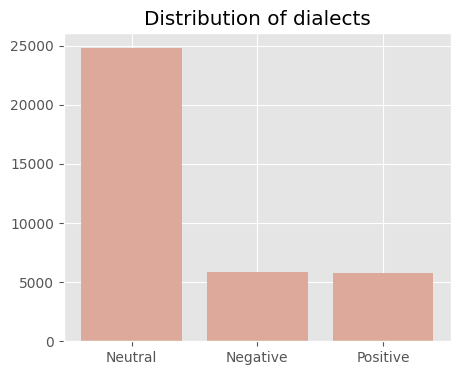

In [ ]:
fig = plt.figure(figsize =(5, 4))
plt.bar(train['sentiment'].value_counts().index, train['sentiment'].value_counts(),color ='#DCA99A');
plt.title("Distribution of dialects");

## Prepare Data and model

In [ ]:
train['sentiment'] = train['sentiment'].map({'Neutral': 0, 'Negative': 1, 'Positive': 2})
val['sentiment'] = val['sentiment'].map({'Neutral': 0, 'Negative': 1, 'Positive': 2})
test['sentiment'] = test['sentiment'].map({'Neutral': 0, 'Negative': 1, 'Positive': 2})

In [ ]:
test.head()

,text,sentiment
27992,اس تي سي والله مااسامحكم لين يوم القيامه,1
3835,اللهم ارني عجاءب قدرتك في تيسير اموري,0
31348,يارب ايام تقول لي سمّي وهذا مطلبك\n\n حسابالمواطن,0
39072,والله stc لو م تشوفون حل بنتكم المضروب ذا طول ...,1
24707,السودان تسجيل اصابه جديده بفيروس كورونا ليرتف...,0


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('aubmindlab/bert-base-arabertv02-twitter', num_labels=len(train['sentiment'].unique()))
tokenizer = BertTokenizerFast.from_pretrained('aubmindlab/bert-base-arabertv02-twitter')

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02-twitter were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmi

### Encode text & prepare dataloader

In [ ]:
train_encodings = tokenizer(train['text'].to_list(), truncation=True, padding=True, max_length=60)
val_encodings = tokenizer(val['text'].to_list(), truncation=True, padding=True, max_length=60)
test_encodings = tokenizer(test['text'].to_list(), truncation=True, padding=True, max_length=60)

In [ ]:
train_labels = train['sentiment']
val_labels = val['sentiment']
test_labels = test['sentiment']

In [ ]:
class SentimentDataset(Dataset):
  def __init__(self, encodings, labels):
      self.encodings = encodings
      self.labels = labels.to_list()

  def __getitem__(self, idx):
      item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
      item['labels'] = torch.tensor(self.labels[idx])
      return item

  def __len__(self):
      return len(self.labels)

In [ ]:
ds_train = SentimentDataset(train_encodings, train_labels)
ds_val =  SentimentDataset(val_encodings, val_labels)
ds_test =  SentimentDataset(test_encodings, test_labels)

### Training Arguments

In [ ]:
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  acc = accuracy_score(labels, predictions)
  return {
      'accuracy': acc,
  }

In [ ]:
training_args = TrainingArguments(
    output_dir='results',          
    num_train_epochs=2,              
    per_device_train_batch_size=64, 
    per_device_eval_batch_size=32,       
    evaluation_strategy = "epoch",        
    save_strategy = 'epoch',
    )

trainer = Trainer(
    model=model,                         
    args=training_args,                 
    train_dataset=ds_train,
    eval_dataset=ds_val,                       
    compute_metrics=compute_metrics
)

## Training

In [ ]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.456900,0.404455,0.829724
2,0.321500,0.422312,0.829219


TrainOutput(global_step=1142, training_loss=0.3778289220379029, metrics={'train_runtime': 755.6481, 'train_samples_per_second': 96.622, 'train_steps_per_second': 1.511, 'total_flos': 2251223068963680.0, 'train_loss': 0.3778289220379029, 'epoch': 2.0})

## Testing

In [ ]:
preds = trainer.predict(ds_test)

In [ ]:
y_pred = [np.argmax(i, axis=-1) for i  in preds.predictions]
y_test = ds_test.labels

In [ ]:
accuracy_score(y_test, y_pred)

0.8341239980369703

## Interpretability tool 
- Captum: https://github.com/pytorch/captum

- transformers-interpret: https://github.com/cdpierse/transformers-interpret

- Lime: https://github.com/marcotcr/lime

- GradCam: https://github.com/jacobgil/pytorch-grad-cam

In [ ]:
cls_explainer = SequenceClassificationExplainer(
    model,
    tokenizer)

def interpret(explainer,text,TrueClass,name):
  word_attributions = explainer(text)
  explainer.visualize(name,true_class=TrueClass)
  return word_attributions

In [ ]:
word_attributions = interpret(cls_explainer,"نظام ظالم هو باين طول الترم",1,'exp')

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,LABEL_1 (0.93),LABEL_1,0.86,[CLS] نظام ظالم هو باين طول الترم [SEP]


In [ ]:
word_attributions = interpret(cls_explainer,"سعيدة جدا اليوم",2,'exp')

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2,LABEL_2 (0.95),LABEL_2,1.20,[CLS] سعيدة جدا اليوم [SEP]
